# Surrogate (snntorch) vs Eventprop Comparison

In [14]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

import tonic
from yingyang.dataset import YinYangDataset

import yaml
import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [16]:
data_config = {
    "seed": 42,
    "dataset": "ying_yang",
    "deterministic": True,
    "batch_size": 128,
    "encoding": "latency",
    "T": 30,
    "dt": 1e-3,
    "t_min": 2,
}

In [17]:
torch.manual_seed(data_config["seed"])
np.random.seed(data_config["seed"])
random.seed(data_config["seed"])

data_config["dataset"] = data_config["dataset"]
if data_config["deterministic"]:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

if data_config["dataset"] == "mnist":
    train_dataset = datasets.MNIST(
        data_config["data_folder"],
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    )
    test_dataset = datasets.MNIST(
        data_config["data_folder"],
        train=False,
        download=True,
        transform=transforms.ToTensor(),
    )
elif data_config["dataset"] == "ying_yang":
    train_dataset = YinYangDataset(size=60000, seed=data_config["seed"])
    test_dataset = YinYangDataset(size=10000, seed=data_config["seed"] + 2)

else:
    raise ValueError("Invalid dataset name")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=data_config["batch_size"], shuffle=True, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=data_config["batch_size"], shuffle=False, drop_last=True
)

## Models

In [18]:
from eventprop.models import SNN, SpikingLinear_ev, SpikingLinear_su

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_config = {
    "T": data_config["T"],
    "dt": data_config["dt"],
    "tau_m": 20e-3,
    "tau_s": 5e-3,
    "mu": 10,
    "resolve_silent": False,
    "n_hid": None,
    "device": device,
    "get_first_spikes": False,
}

n_ins = {"mnist": 784, "ying_yang": 4 if data_config["encoding"] == "latency" else 4}
n_outs = {"mnist": 10, "ying_yang": 3}

dims = [n_ins[data_config["dataset"]]]
if model_config["n_hid"] is not None and isinstance(model_config["n_hid"], list):
    dims.extend(model_config["n_hid"])
elif isinstance(model_config["n_hid"], int):
    dims.append(model_config["n_hid"])
dims.append(n_outs[data_config["dataset"]])

In [20]:
snntorch_model = SNN(dims, str(SpikingLinear_su), **model_config).to(device)
eventprop_model = SNN(dims, str(SpikingLinear_ev), **model_config).to(device)
eventprop_model.layers[0].weight.data = snntorch_model.layers[0].weight.data
models = {"snntorch": snntorch_model, "eventprop": eventprop_model}

## Behavior Comparison

In [21]:
from eventprop.training import encode_data

### Voltage plot check

In [22]:
data, targets = next(iter(test_loader))
data = data.to(device)
spikes = encode_data(data, data_config)
outs = {n: model(spikes) for n, model in models.items()}

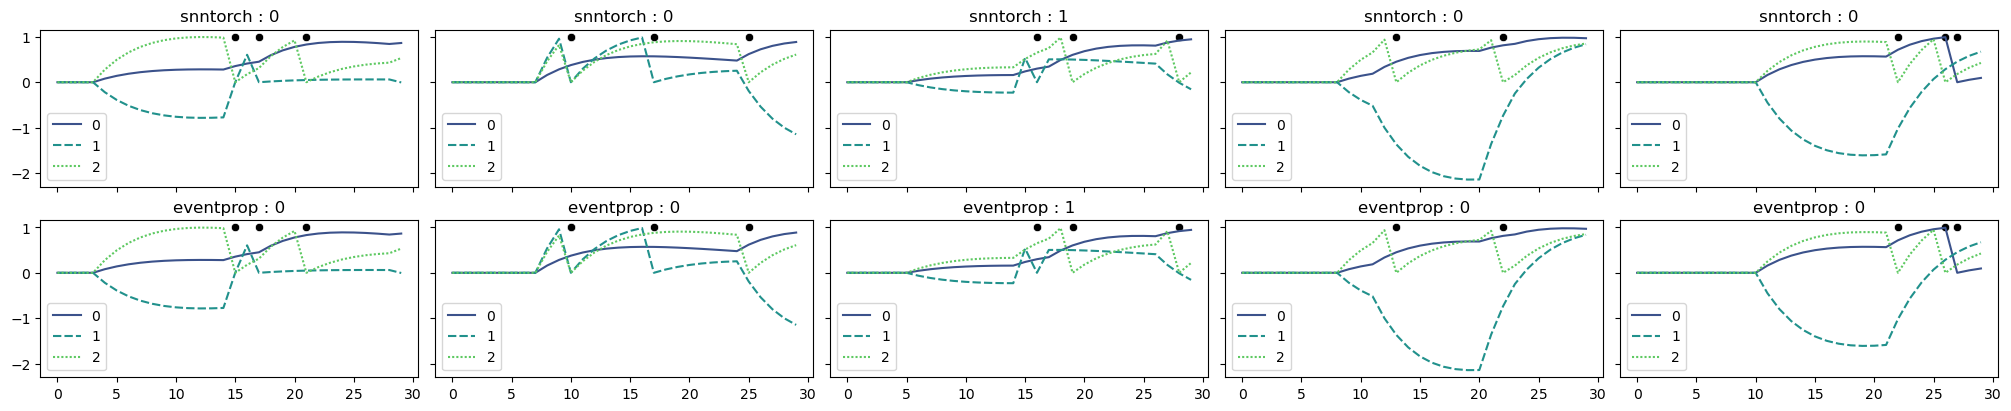

In [23]:
fig, axs = plt.subplots(
    2, 5, figsize=(20, 4), sharex=True, sharey=True, constrained_layout=True
)
for t, (ax_model, target) in enumerate(zip(axs.T, targets)):
    for ax, (name, out) in zip(ax_model, outs.items()):
        voltages = out[1][0][1][:, t].cpu().detach().numpy()
        spikes = out[1][0][0][:, t].cpu().detach().numpy()
        sns.lineplot(voltages, palette="viridis", ax=ax)
        sns.scatterplot(
            x=np.where(spikes)[0],
            y=np.ones_like(np.where(spikes)[0]),
            ax=ax,
            color="black",
        )
        ax.set_title(f"{name} : {target}")
        # ax.hlines(1, 0, 30, color="black", linestyle="--")
        # ax.set_xticks(range(30))
        # ax.vlines(np.where(spikes)[0],voltages.min()*np.ones_like(np.where(spikes)[0]),  np.ones_like(np.where(spikes)[0]))
        # ax.set_yticks([0, 1])
        # ax.grid()

### Firing rates check

In [24]:
counts = [0, 0]
frs = [0, 0]
n_batch = len(train_loader)
for (data, target), _ in zip(tqdm(train_loader, total=n_batch), range(n_batch)):
    data, target = data.to(device), target.to(device)
    spikes_data = encode_data(data, data_config)
    snn_out = models["snntorch"](spikes_data)
    event_out = models["eventprop"](spikes_data)
    counts = [
        c + out[0].unique(return_counts=True)[1]
        for c, out in zip(counts, [snn_out, event_out])
    ]
    for f, s in enumerate([snn_out, event_out]):
        frs[f] += s[0].float().sum(0).mean(0)
frs = torch.stack(frs) / n_batch
frs, counts

  0%|          | 0/468 [00:00<?, ?it/s]

(tensor([[0.4465, 0.9094, 2.0466],
         [0.4465, 0.9094, 2.0466]], grad_fn=<DivBackward0>),
 [tensor([5187538,  203822]), tensor([5187538,  203822])])

In [25]:
raise KeyboardInterrupt

KeyboardInterrupt: 

## Training

In [55]:
from eventprop.training import train_model, test
from snntorch.functional.loss import (
    ce_temporal_loss,
    SpikeTime,
    ce_rate_loss,
    ce_count_loss,
)
from eventprop.config import make_dc

In [70]:
first_spike_fn = SpikeTime().first_spike_fn
training_config = {
    "n_epochs": 10,
    "loss": "ce_temporal",
    "first_spike_fn": first_spike_fn,
    'alpha' : 0.
}

optim_config = {"lr": 1e-3, "weight_decay": 0, "optimizer": "adam"}

optimizers_type = {"adam": torch.optim.Adam, "sgd": torch.optim.SGD}
optimizers = {
    n: optimizers_type[optim_config["optimizer"]](
        model.parameters(),
        lr=optim_config["lr"],
        weight_decay=optim_config["weight_decay"],
    )
    for n, model in models.items()
}

In [71]:
def get_flat_dict_from_nested(config):
    flat_dict = {}
    for key, value in config.items():
        if isinstance(value, dict):
            flat_dict.update(get_flat_dict_from_nested(value))
        else:
            flat_dict[key] = value
    return flat_dict

In [72]:
config = {
    "data": data_config,
    "model": model_config,
    "training": training_config,
    "optim": optim_config,
}
flat_config = get_flat_dict_from_nested(config)
args = make_dc(flat_config)(**flat_config)
loaders = {"train": train_loader, "test": test_loader}

if args.loss == "ce_temporal":
    criterion = ce_temporal_loss()
elif args.loss == "ce_rate":
    criterion = ce_rate_loss()
elif args.loss == "ce_count":
    criterion = ce_count_loss()
else:
    raise ValueError("Invalid loss type")

In [74]:
train_results = {
    n: train_model(
        model, criterion, optimizers[n], loaders, args, first_spike_fn=first_spike_fn
    )
    for n, model in models.items()
}

 | :   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [62]:
pbar = tqdm(total=len(test_loader))

  0%|          | 0/78 [00:00<?, ?it/s]

In [63]:
pbar.desc

''